In [3]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import time
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import KeyedVectors

lem = WordNetLemmatizer()

In [100]:
#function to find English words

def isEnglish(s):
    try:
        s.encode('ascii')
    except UnicodeEncodeError:
        return False
    else:
        return True

In [3]:
#load the complete list from imdb

f = pd.read_table('title.basics.tsv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ftype = f['genres'][0]
ftype
#f['startYear'][0]

'Documentary,Short'

In [45]:
# get the dataframe containing only the documentary genre with titles in English

df = f.loc[f['genres'] == ftype]
df = df[['tconst', 'primaryTitle', 'startYear']]

df = df.reset_index(drop = True)
#this resultant dataframe contains only the 3 columns - title, year and imdb ID


idx = []

for i in range(len(df)):
    if isEnglish(df['primaryTitle'][i]) == True:
        idx.append(i)
        
df = df.iloc[idx, :].reset_index(drop = True)
    
print(len(df[pd.to_numeric(df['startYear'], errors='coerce').isnull()]))
df['startYear'] = pd.to_numeric(df['startYear'], errors='coerce')
print(len(df))

if len(df[df['startYear'].isnull()].index.tolist()) != 0:
    df.dropna(inplace=True)
print(df[df['startYear'].isnull()].index.tolist())
print(len(df))

#df.loc[df[pd.to_numeric(df['startYear'], errors='coerce').isnull()]]
df.head()

290
86017
[]
85727


,tconst,primaryTitle,startYear
0,tt0000001,Carmencita,1894.0
1,tt0000008,Edison Kinetoscopic Record of a Sneeze,1894.0
2,tt0000010,Exiting the Factory,1895.0
3,tt0000011,Akrobatisches Potpourri,1895.0
4,tt0000012,The Arrival of a Train,1896.0


In [46]:
df = df[df['startYear'] >= 1970]
df = df.reset_index(drop = True)
print(len(df))
df['description'] = 'None'
df.head()

53365


,tconst,primaryTitle,startYear,description
0,tt0065508,Bylem zolnierzem,1971.0,None
1,tt0065779,The Gifts,1970.0,None
2,tt0065998,A Long Way from Nowhere,1970.0,None
3,tt0066100,On vous parle de Paris: Maspero. Les mots ont ...,1970.0,None
4,tt0066149,Japan and the Japanese,1970.0,None


In [40]:
d = df.tail(100)
d = d.reset_index(drop = True)

In [47]:
# get the description of the documentaries from IMDB
start_time = time.time()

for i in range(len(df)):
    j = df['tconst'][i]
    link = requests.get('https://www.imdb.com/title/'+ str(j) + '/plotsummary?ref_=tt_ov_pl')
    soup = BeautifulSoup(link.text, 'html.parser')
    try:
        desc = soup.find('li', class_ = 'ipl-zebra-list__item').find('p').text
        df['description'][i] = desc
    except:
        pass

print(time.time() - start_time)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


27312.92974114418


In [48]:
df.tail()

,tconst,primaryTitle,startYear,description
53360,tt9630474,Papirnati zivot,2017.0,It looks like we don't have any Plot Summaries...
53361,tt9630618,Linguagem,2014.0,It looks like we don't have any Plot Summaries...
53362,tt9630646,Carta a uma Jovem Cineasta,2014.0,It looks like we don't have any Plot Summaries...
53363,tt9630964,Ruta 60,2018.0,It looks like we don't have any Plot Summaries...
53364,tt9631114,Sweet Memories,2012.0,Mullan Mews and Sydenham Court are bespoke sup...


In [49]:
df.to_csv('imdb_desc_all.csv', index = False, header = True)

In [50]:
dlist = df.copy()

In [53]:
len(dlist)

53365

In [54]:
dlist.drop(dlist[dlist['description'].str.startswith('It looks')].index, inplace = True)

In [14]:
dlist = dlist.reset_index(drop = True)

In [59]:
print(len(dlist))
dlist = dlist.reset_index(drop = True)
dlist['startYear'] = dlist['startYear'].astype(int)
dlist.to_csv('imdb_desc.csv', index = False, header = True)

23107


In [68]:
# clean the text in the description column of the dataframe

def clean_df_data(d):
    d = d.str.lower()
    d = d.str.replace('\n', ' ')
    d = d.str.replace('\t', ' ')
    for i in range(len(d)):
        d[i] = d[i].translate(d[i].maketrans(' ', ' ', string.punctuation))
    return d

In [69]:
clean_df_data(dlist['description'])
dlist.head()

,tconst,primaryTitle,startYear,description
0,tt0065508,Bylem zolnierzem,1971,"Blind war veterans tell stories about loss, wa..."
1,tt0065779,The Gifts,1970,Water pollution in the United States: an early...
2,tt0065998,A Long Way from Nowhere,1970,The film traces the progress of four autistic ...
3,tt0066748,Adventures in Perception,1972,An introduction to the work of graphic artist ...
4,tt0066786,Art Is...,1972,"""What is art?"" The film offers some new answer..."


In [49]:
def clean_data(string_text):
    string_text = string_text.lower()
    string_text = string_text.strip()
    string_text = string_text.translate(string_text.maketrans(' ',
                        ' ', string.punctuation))
    string_text = string_text.replace('\n', ' ')
    string_text = string_text.replace('\t', ' ')
    return string_text

In [81]:
for i in range(len(dlist)):
    dlist['description'][i] = clean_data(dlist['description'][i])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,tconst,primaryTitle,startYear,description,desc_words
0,tt0065508,Bylem zolnierzem,1971,blind war veterans tell stories about loss war...,"Bln wr veern ell re bu l, wr, wll lve n her re."
1,tt0065779,The Gifts,1970,water pollution in the united states an early ...,Wer pllun n he Une Se: n erl wrnng pruce fr he...
2,tt0065998,A Long Way from Nowhere,1970,the film traces the progress of four autistic ...,The fl rce he prgre f fur uc chlren ver ne er ...
3,tt0066748,Adventures in Perception,1972,an introduction to the work of graphic artist ...,An nrucn he wrk f grphc r M.C. Echer.
4,tt0066786,Art Is...,1972,what is art the film offers some new answers t...,"""Wh r?"" The fl ffer e new nwer he ge l quen."


In [92]:
# remove stopwords from the description column of the dataframe
dlist['desc_words'] = 'None'

def remove_df_stopwords(d):
    for i in range(len(d)):
        sentence = []
        for word in d['description'][i].split():
            if word not in stopwords.words('english'):
                sentence.append(word)
        d['desc_words'][i] = ' '.join(sentence)

In [ ]:
remove_df_stopwords(dlist)

In [5]:
dlist.to_csv('imdb_desc_words.csv', header = True, index = False)

(-0.5, 399.5, 199.5, -0.5)

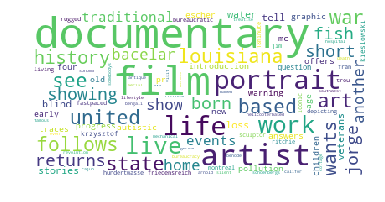

In [113]:
#from PIL import Image
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#stop_words = stopwords.words('english').append(['film', 'documentary', 'director'])
#word_cloud = WordCloud(background_color='white', max_words=100, stopwords = stop_words,
#                max_font_size=50,random_state=42).generate(str(dlist['desc_words']))

#print(word_cloud)
#plt.imshow(word_cloud)
#plt.axis('off')

In [ ]:
dlist.drop(dlist.loc[dlist['description'] == 'none'].index, inplace = True)
if len(dlist.loc[dlist['desc_words'] == 'None'].index.tolist()) == 0:
    print('no null value')

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',stop_words= 'english', ngram_range=(1,1))

def get_keywords(desc):
    train_vect = tfidf.fit_transform(desc)
    words = list(tfidf.vocabulary_.keys())[:5]
    return words

In [8]:
dlist['keywords'] = 'None'
for i in range(len(dlist)):
    try:
        dlist['keywords'][i] = get_keywords(dlist['description'][i].split())
    except:
        dlist['keywords'][i] = dlist['description'][i].split()[:5]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
dlist.head()

,tconst,primaryTitle,startYear,description,desc_words,keywords
0,tt0065508,Bylem zolnierzem,1971,blind war veterans tell stories about loss war...,blind war veterans tell stories loss war live ...,"[blind, war, veterans, tell, stories]"
1,tt0065779,The Gifts,1970,water pollution in the united states an early ...,water pollution united states early warning pr...,"[water, pollution, united, states, early]"
2,tt0065998,A Long Way from Nowhere,1970,the film traces the progress of four autistic ...,film traces progress four autistic children on...,"[film, traces, progress, autistic, children]"
3,tt0066748,Adventures in Perception,1972,an introduction to the work of graphic artist ...,introduction work graphic artist mc escher,"[introduction, work, graphic, artist, mc]"
4,tt0066786,Art Is...,1972,what is art the film offers some new answers t...,art film offers new answers age old question,"[art, film, offers, new, answers]"


In [16]:
dlist['w2v'] = [[]] * dlist.shape[0]

In [168]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',
                   binary=True, limit = 500000)

In [169]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    return np.mean(word2vec_model[doc], axis=0)

In [23]:
for idx, rows in dlist.iterrows():
    dlist['w2v'][idx] = document_vector(model, rows['desc_words'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
dlist.head()

,tconst,primaryTitle,startYear,description,desc_words,keywords,w2v
0,tt0065508,Bylem zolnierzem,1971,blind war veterans tell stories about loss war...,blind war veterans tell stories loss war live ...,"[blind, war, veterans, tell, stories]","[-0.16313477, 0.14085694, -0.01907959, 0.12058..."
1,tt0065779,The Gifts,1970,water pollution in the united states an early ...,water pollution united states early warning pr...,"[water, pollution, united, states, early]","[-0.16641583, 0.1179628, -0.011660805, 0.13811..."
2,tt0065998,A Long Way from Nowhere,1970,the film traces the progress of four autistic ...,film traces progress four autistic children on...,"[film, traces, progress, autistic, children]","[-0.18571264, 0.11501144, 0.016085012, 0.13528..."
3,tt0066748,Adventures in Perception,1972,an introduction to the work of graphic artist ...,introduction work graphic artist mc escher,"[introduction, work, graphic, artist, mc]","[-0.21546805, 0.10590994, -0.02231794, 0.15802..."
4,tt0066786,Art Is...,1972,what is art the film offers some new answers t...,art film offers new answers age old question,"[art, film, offers, new, answers]","[-0.18348424, 0.12162332, -0.0062794406, 0.130..."


In [ ]:
dlist.to_pickle('imdb_w2v.pkl', header = True, index = False)